In [73]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, RandomFlip, RandomRotation
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
import random
from skimage import io, transform, exposure
from sklearn.metrics import classification_report

### Load data V1:

This method does not inclue a shufffle, and all images from a class are one after another.
? Can this lead to overfitting?

In [9]:
image_list = []
labels_list = []
classes = 43

root_dir=r'D:\Faculty materials\bachelors\datasets\GTSRB\Train'

try:
    for traffic_sign_class in range(classes):
        print(f"[INFO] Processing {traffic_sign_class} ...")
        path = os.path.join(root_dir, str(traffic_sign_class))
        traffic_sign_class_images = os.listdir(path)
        for image in traffic_sign_class_images:
            try:
                img = Image.open(path + "/" + image)
                img = img.resize((45, 45))
                img = np.array(img)
                image_list.append(img)
                labels_list.append(traffic_sign_class)
            except Exception as err:
                print(f"[ERROR]: On loading image!")

except Exception as err:
    print(f"[ERROR]: {err}")

image_list = np.array(image_list, dtype=np.float16) / 255.0 # the image_list is normalized and converted to np array
labels_list = np.array(labels_list)

[INFO] Processing 0 ...
D:\Faculty materials\bachelors\datasets\GTSRB\Train\0
[INFO] Processing 1 ...
D:\Faculty materials\bachelors\datasets\GTSRB\Train\1
[INFO] Processing 2 ...
D:\Faculty materials\bachelors\datasets\GTSRB\Train\2
[INFO] Processing 3 ...
D:\Faculty materials\bachelors\datasets\GTSRB\Train\3
[INFO] Processing 4 ...
D:\Faculty materials\bachelors\datasets\GTSRB\Train\4
[INFO] Processing 5 ...
D:\Faculty materials\bachelors\datasets\GTSRB\Train\5
[INFO] Processing 6 ...
D:\Faculty materials\bachelors\datasets\GTSRB\Train\6
[INFO] Processing 7 ...
D:\Faculty materials\bachelors\datasets\GTSRB\Train\7
[INFO] Processing 8 ...
D:\Faculty materials\bachelors\datasets\GTSRB\Train\8
[INFO] Processing 9 ...
D:\Faculty materials\bachelors\datasets\GTSRB\Train\9
[INFO] Processing 10 ...
D:\Faculty materials\bachelors\datasets\GTSRB\Train\10
[INFO] Processing 11 ...
D:\Faculty materials\bachelors\datasets\GTSRB\Train\11
[INFO] Processing 12 ...
D:\Faculty materials\bachelors\data

In [ ]:
print(f"Image list shape: {image_list.shape}")
print(f"Labels list shape: {labels_list.shape}")

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(image_list, labels_list, test_size=0.2, random_state=42)

In [ ]:
# convert the labels

y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

### Load data V2:

In [24]:
csv_path_train = r"D:\Faculty materials\bachelors\datasets\GTSRB\Train.csv"
csv_path_test = r"D:\Faculty materials\bachelors\datasets\GTSRB\Test.csv"
dataset_path = r"D:\Faculty materials\bachelors\datasets\GTSRB"

def load_data(csv_path):
    image_list = []
    labels_list = []
    classes = 43

    rows = open(csv_path).read().strip().split("\n")[1:]
    random.shuffle(rows)

    for (i, row) in enumerate(rows):
        if i > 0 and i % 1000 == 0:
            print(f"[INFO] processed {i} images...")
        (label, image_path) = row.strip().split(",")[-2:]
        image_path = os.path.join(dataset_path, image_path)
        image = io.imread(image_path)
        image = transform.resize(image, (45, 45))
        # image = exposure.equalize_adapthist(image, clip_limit=0.1)
        image_list.append(image)
        labels_list.append(label)

    image_list = np.array(image_list, dtype=np.float32) / 255.0
    labels_list = np.array(labels_list)
    return image_list, labels_list


In [67]:
print("[INFO] loading train and test images...")
image_list, labels_list = load_data(csv_path_train)
x_train, x_val, y_train, y_val = train_test_split(image_list, labels_list, test_size=0.2, random_state=42)
x_test, y_test = load_data(csv_path_test)

y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

total_class = y_train.sum(axis=0)
class_weights = dict()

for i in range(0, len(total_class)):
    class_weights[i] = total_class.max() / total_class[i]

[INFO] loading train and test images...
[INFO] processed 1000 images...
[INFO] processed 2000 images...
[INFO] processed 3000 images...
[INFO] processed 4000 images...
[INFO] processed 5000 images...
[INFO] processed 6000 images...
[INFO] processed 7000 images...
[INFO] processed 8000 images...
[INFO] processed 9000 images...
[INFO] processed 10000 images...
[INFO] processed 11000 images...
[INFO] processed 12000 images...
[INFO] processed 13000 images...
[INFO] processed 14000 images...
[INFO] processed 15000 images...
[INFO] processed 16000 images...
[INFO] processed 17000 images...
[INFO] processed 18000 images...
[INFO] processed 19000 images...
[INFO] processed 20000 images...
[INFO] processed 21000 images...
[INFO] processed 22000 images...
[INFO] processed 23000 images...
[INFO] processed 24000 images...
[INFO] processed 25000 images...
[INFO] processed 26000 images...
[INFO] processed 27000 images...
[INFO] processed 28000 images...
[INFO] processed 29000 images...
[INFO] proce

In [86]:
print(x_train.shape[1:])

(45, 45, 3)


In [87]:
model = Sequential()
model.add(Conv2D(filters=24, kernel_size=(3,3), activation='relu', input_shape=x_train.shape[1:]))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(filters=24, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=48, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

model.summary()

d:\Faculty materials\BACHELORS-THESIS\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (None, 43, 43, 24)     │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 43, 43, 24)     │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 41, 41, 24)     │         5,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 41, 41, 24)     │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 20, 20, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 18, 18, 32)     │         6,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 18, 18, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 6, 6, 48)       │        13,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 3, 3, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 432)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       221,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 280,147 (1.07 MB)

 Trainable params: 279,923 (1.07 MB)

 Non-trainable params: 224 (896.00 B)

In [88]:
BS = 32
EPOCH = 20

In [89]:
aug = ImageDataGenerator(rotation_range=10,
                         zoom_range=0.15,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.15,
                         horizontal_flip=False,
                         vertical_flip=False,
                         fill_mode='nearest')

In [92]:
print("[INFO] Compiling the model...")
optim = Adam(learning_rate=1e-3)
model.compile(optimizer=optim,
              loss='categorical_crossentropy', metrics=["accuracy"])

print("[INFO] Training the model...")
history = model.fit(aug.flow(x_train, y_train, batch_size=BS), validation_data=(x_val, y_val), epochs=EPOCH)
model.save("TSR_CNN1_second_try3.h5")

[INFO] Compiling the model...
[INFO] Training the model...
Epoch 1/20


d:\Faculty materials\BACHELORS-THESIS\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


981/981 ━━━━━━━━━━━━━━━━━━━━ 90s 88ms/step - accuracy: 0.9894 - loss: 0.0436 - val_accuracy: 0.0128 - val_loss: 48.4304
Epoch 2/20
169/981 ━━━━━━━━━━━━━━━━━━━━ 1:09 86ms/step - accuracy: 0.9861 - loss: 0.0772

KeyboardInterrupt: 

In [91]:
sign_labels = open("SignsNames.csv").read().strip().split("\n")[1:]
sign_labels = [l.split(",")[1] for l in sign_labels]

print("[INFO] evaluating the model...")
predictions = model.predict(x_test, batch_size=BS)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=sign_labels))

[INFO] evaluating the model...
395/395 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step
                                                            precision    recall  f1-score   support

                                      Speed limit (20km/h)       0.00      0.00      0.00        60
                                      Speed limit (30km/h)       0.15      0.01      0.03       720
                                      Speed limit (50km/h)       0.30      0.06      0.10       750
                                      Speed limit (60km/h)       0.00      0.00      0.00       450
                                      Speed limit (70km/h)       0.00      0.00      0.00       660
                                      Speed limit (80km/h)       0.07      0.01      0.02       630
                               End of speed limit (80km/h)       0.29      0.01      0.03       150
                                     Speed limit (100km/h)       0.00      0.00      0.00       450
                          

d:\Faculty materials\BACHELORS-THESIS\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Faculty materials\BACHELORS-THESIS\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Faculty materials\BACHELORS-THESIS\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

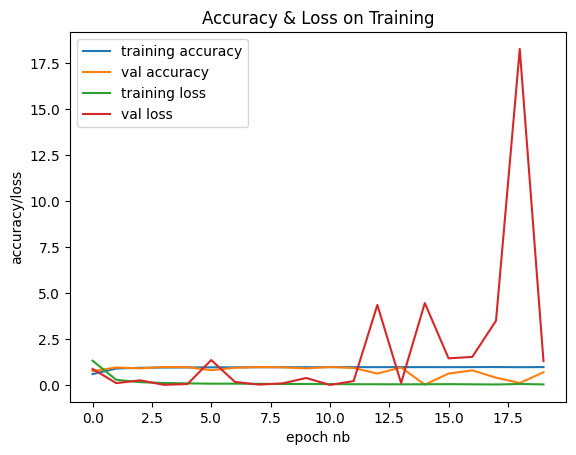

In [75]:
N = np.arange(0, EPOCH)
plt.figure()
plt.plot(N, history.history['accuracy'], label='training accuracy')
plt.plot(N, history.history['val_accuracy'], label='val accuracy')
plt.plot(N, history.history['loss'], label='training loss')
plt.plot(N, history.history['val_loss'], label='val loss')
plt.title('Accuracy & Loss on Training')
plt.xlabel('epoch nb')
plt.ylabel('accuracy/loss')
plt.legend()
plt.show()

In [84]:
# from keras.models import load_model

l = []

img = Image.open("00130.png")
img = img.resize((45, 45))
img = np.array(img)
l.append(img)

image_list = np.array(l, dtype=np.float16) / 255.0

# loaded_model = load_model("TSR_CNN1_first_try_aug.h5")
p = model.predict(image_list)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


In [85]:
j = p.argmax(axis=1)[0]
print(sign_labels[j+1])

Go straight or right
